**GOAL:** The purpose of this project is to merge two separate images to create a new one. The generated image (G) will combine the content from one image (referred to as the **'content' image, C**) with the style from another image (referred to as the **'style' image, S**).

**Method:** The approach involves utilizing a pretrained model named VGG-19, which has been trained on a very large ImageNet database, to extract low-level and high-level features from the two images, C and S. Subsequently, a loss function will be constructed to take into account the similarity in content and style between the images. Following this, the image G will be generated and optimized so that the loss function reaches the lowest possible values. (In this approach, the parameter will not be optimized)

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/style_transfer.ipynb#scrollTo=3TLljcwv5qZs
https://www.tensorflow.org/tutorials/generative/style_transfer

# 0) Import and configure modules

In [ ]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import IPython.display as display
import time
import math

# 1) Load and show image

In [ ]:
#load image from image URL
style_path = tf.keras.utils.get_file(fname='s_image.jpg', origin='https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')
content_path = tf.keras.utils.get_file(fname='c_image.jpg', origin='https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Eiffel_Tower_at_night%2C_Paris_24_June_2021_03.jpg/479px-Eiffel_Tower_at_night%2C_Paris_24_June_2021_03.jpg?20210705140135')

81101/81101 [==============================] - 0s 1us/step


In [ ]:
# function to load and preprocess the image
def load_img(path_to_img):
    """
    Load and preprocess the image.

    Args:
    - path_to_img (str): The file path to the image to be loaded.

    Returns:
    - img (tf.Tensor): The preprocessed image tensor with shape (1, n_h, n_W, n_C),
                       The pixel values are in the range [0.0, 1.0].
    """

    # load, decode and normalize the image to range [0.0, 1.0]
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) # convert  dtype to float32 to implement resize (mulmat, devide into float)

    # resize the image to have both dims (width and height) with maximum = 512
    max_dim = 512
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape) # find the longer dim
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)

    # expand the batch dimension, so that, it could be fed into model in Tensorflow
    img = img[tf.newaxis, :]

    return img

In [ ]:
#  function to display an image
def imshow(image, title=None):
    """
    Display the image.

    Args:
    - image (tf.Tensor): The image tensor to be displayed. If can has a batch dimension or not. If so, it will be squeezed.
    - title (str, optional): The title to be displayed above the image.

    Returns:
    None
    """
    # remode the batch dimension if image has batch dimension
    if len(image.shape) > 3:
        image = tf.squeeze(image)

    # show the image
    plt.imshow(image)
    plt.axis('off')
    if title:
        plt.title(title)


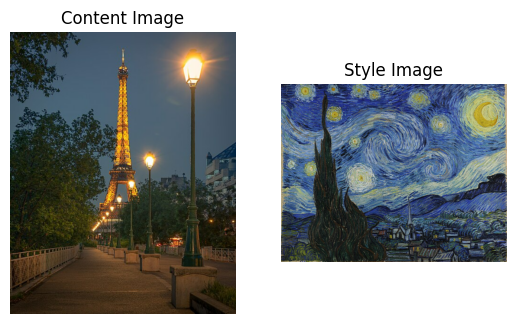

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')
plt.show()

# 2) Load pretrained model

The VGG19 network is a pretrained model used for image classification. We will load this model without its classification head (the 3 fully-connected layers at the top of the model) and utilize the intermediate layers to obtain the content and style representations of the image.

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False,
                                  weights='imagenet') # pre-trained weights of model on ImageNet

80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
# list all the layer names of the model
for layer in vgg.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


We will choose some intermediate layers from the network to represent the style and content of the image.

In [82]:
content_layers = ['block4_conv1']

style_layers = ['block1_conv1',
                'block1_conv2',
                'block2_conv1',
                'block2_conv2',
                'block3_conv1',
                'block3_conv4',
                'block4_conv1',
                'block4_conv4',
                'block5_conv1',
                'block5_conv4']

style_weights = [0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.2, 0.05, 0.2, 0.10]
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)
print(num_content_layers, 'layer is used to represent the content, and ', num_style_layers, 'layers are used to represent the style of images')

1 layer is used to represent the content, and  10 layers are used to represent the style of images


We will build the model with the input is the image and return a list of pre-defined intermediate layer's output.

In [ ]:
def custom_vgg_model(layer_names):

    # load the vgg19 pretrain model, which is trained on ImageNet database
    vgg = tf.keras.applications.VGG19(include_top=False,
                                  weights='imagenet')
    vgg.trainable = False

    # output the intermediate layers's output
    outputs = [vgg.get_layer(name).output for name in layer_names]

    # define the custom model
    model = tf.keras.Model(inputs=[vgg.input], outputs=outputs)

    return model

# create content and generator extractor
style_extractor = custom_vgg_model(style_layers)
style_outputs = style_extractor(style_image*255)

block1_conv1
	shape:  (1, 405, 512, 64)
	min:  0.0
	max:  660.52795
	mean:  23.849983


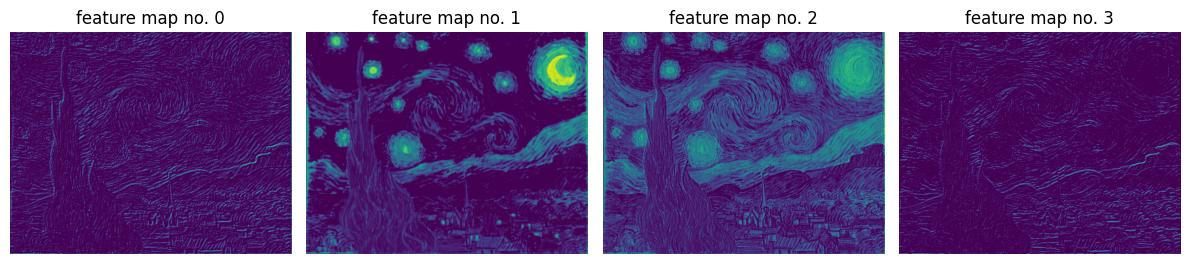

block1_conv2
	shape:  (1, 405, 512, 64)
	min:  0.0
	max:  2122.1748
	mean:  134.62767


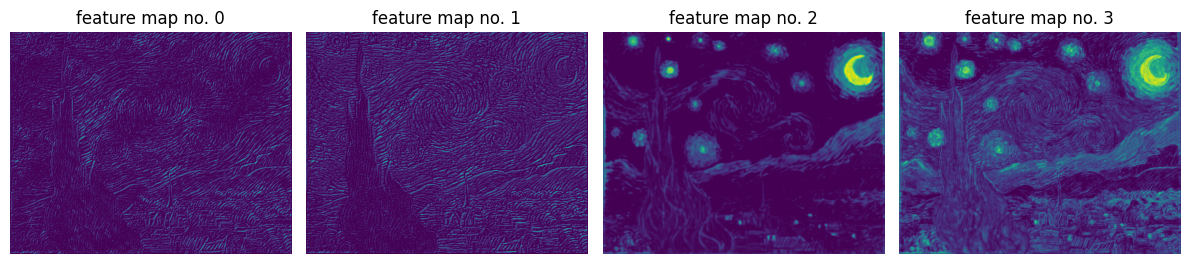

block2_conv1
	shape:  (1, 202, 256, 128)
	min:  0.0
	max:  2981.8284
	mean:  147.914


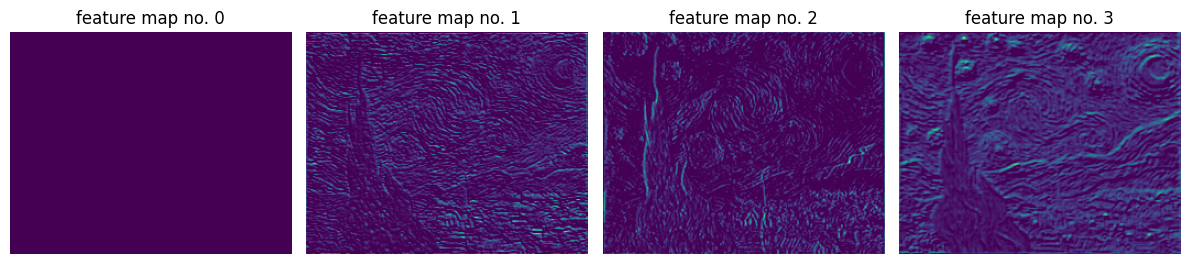

block2_conv2
	shape:  (1, 202, 256, 128)
	min:  0.0
	max:  5419.3037
	mean:  137.86223


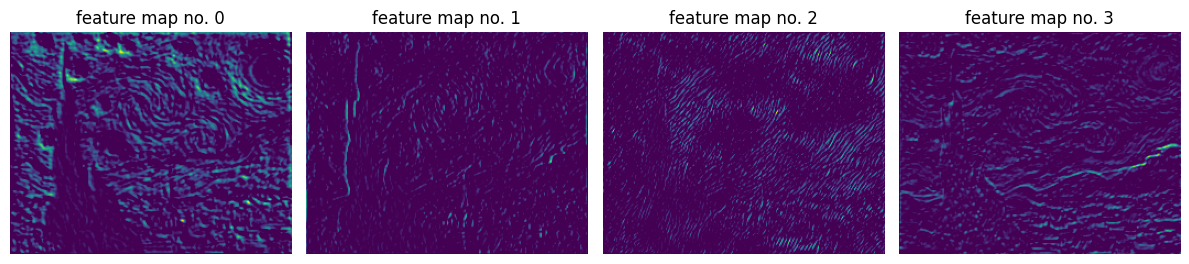

block3_conv1
	shape:  (1, 101, 128, 256)
	min:  0.0
	max:  7421.7754
	mean:  144.36418


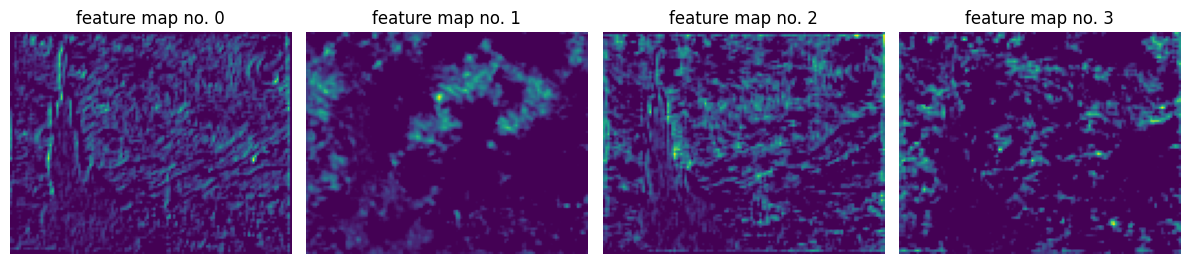

block3_conv4
	shape:  (1, 101, 128, 256)
	min:  0.0
	max:  12620.016
	mean:  622.58484


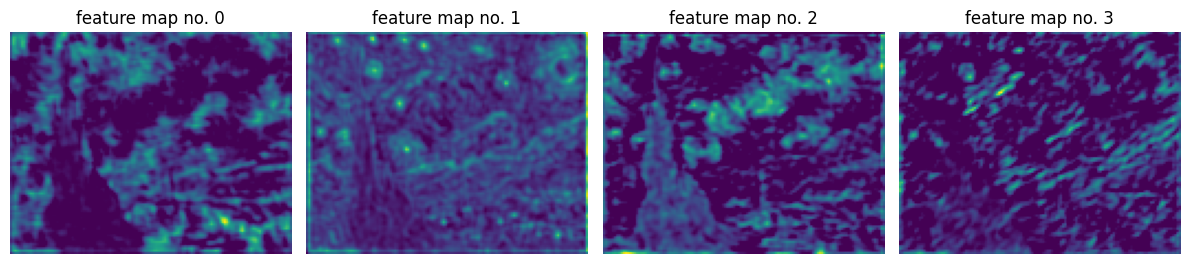

block4_conv1
	shape:  (1, 50, 64, 512)
	min:  0.0
	max:  16733.793
	mean:  560.6592


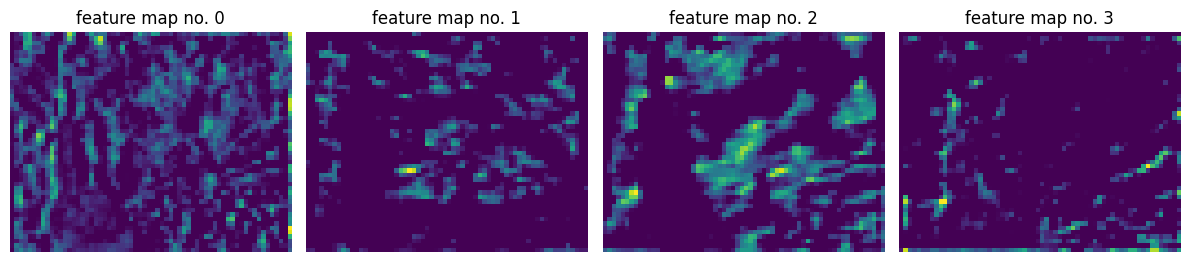

block4_conv4
	shape:  (1, 50, 64, 512)
	min:  0.0
	max:  5896.3447
	mean:  47.443817


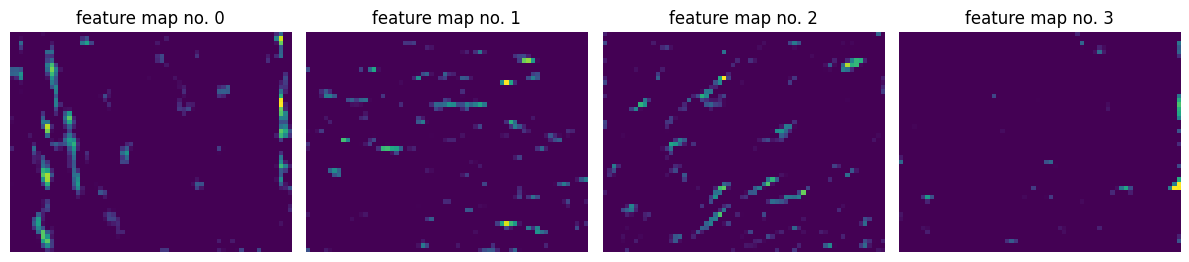

block5_conv1
	shape:  (1, 25, 32, 512)
	min:  0.0
	max:  3804.7952
	mean:  48.127247


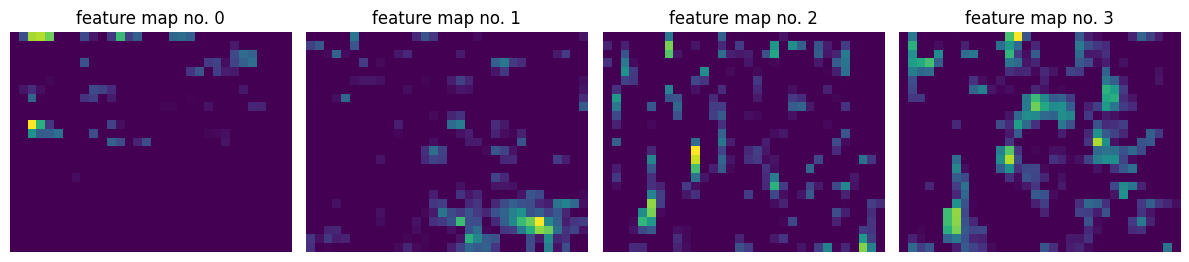

block5_conv4
	shape:  (1, 25, 32, 512)
	min:  0.0
	max:  185.50952
	mean:  1.263511


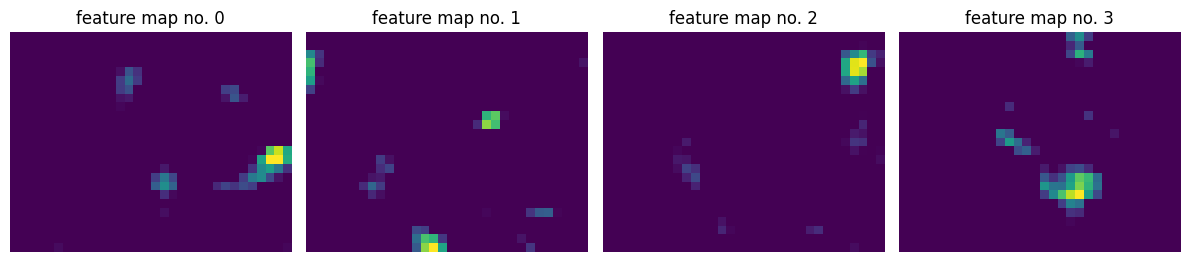

In [ ]:
#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("\tshape: ", output.numpy().shape)
    print("\tmin: ", output.numpy().min())
    print("\tmax: ", output.numpy().max())
    print("\tmean: ", output.numpy().mean())
    plt.figure(figsize=(12,3))
    for i in range(4):

        plt.subplot(1, 4, i+1)
        plt.imshow(output[0, :, :, i])
        plt.axis('off')
        plt.title('feature map no. ' + str(i))
    plt.tight_layout()
    plt.show()
print()

First, we will define the gram_matrix function, which is used to represent the style of an image:

- $G_{ij} (i \neq j)$: how each channel correlates with every other, reflecting the likelihood of 2 patterns occurring together

- $G_{ii}$: the magnitude (the level of activity) of a single channel,  indicating the frequency of patterns used in the image.

The formulation of element $G_{mn}$ of **Gram matrix** of layer $[l]$:

$$G^{[l]}_{mn} = \frac{\sum_{ij} a^{[l]}_{ij,m}a^{[l]}_{ij,n}}{I^{[l]}J^{[l]}}$$


In [ ]:
def gram_matrix(input_tensor):
    """
    Argument:
    input_tensor -- matrix of shape (1, n_H, n_W, n_C)

    Returns:
    gram_matrix -- Gram matrix of A, of shape (n_C, n_C)
    """
    _, n_H, n_W, n_C = input_tensor.shape
    num_locations = tf.cast(n_H * n_W, tf.float32)
    input = tf.transpose(tf.reshape(input_tensor, [-1, n_C]))
    gram_matrix = tf.linalg.matmul(a=input,
                          b=input,
                          transpose_a=False,
                          transpose_b=True)[tf.newaxis, :]


    return gram_matrix/(num_locations)

Now, define the model class.

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, content_layers, style_layers, style_weights):
        super(StyleContentModel, self).__init__()

        self.style_layers = style_layers
        self.content_layers = content_layers
        self.layer_names = style_layers + content_layers
        self.num_style_layers = len(style_layers)
        self.style_weights = style_weights

        self.vgg = custom_vgg_model(self.layer_names)
        self.vgg.trainable = False

    def call(self, inputs):
        """
        Forward pass function of StyleContentModel.

        Args:
            inputs (tensor): Batch of input images with range from [0.0, 1.0]

        Returns:
            dict: Dictionary containing content and style representations of the input images
        """
        # preprocess_input of vgg get the tensor, with values in the range [0, 255]
        inputs = inputs * 255.0

        # cast image to float32 dtype, convert from RGD to BGR, each channel is zero-centered without scaling
        preprocessed_inputs = tf.keras.applications.vgg19.preprocess_input(inputs)

        # extract style and content representation of predefined layers from model
        outputs = self.vgg(preprocessed_inputs)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs] # style representation is under gram matrix

        # organize style and content representation into dictionary
        style_dict = {style_layer: [value, weight]
                      for style_layer, value, weight in zip(self.style_layers, style_outputs, self.style_weight)}
        content_dict = {content_layer: value
                        for content_layer, value in zip(self.content_layers, content_outputs)}

        return {'content': content_dict,
                'style': style_dict}


In [84]:
extractor = StyleContentModel(content_layers, style_layers, style_weights)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, [output, weight] in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.024893675
    max:  24194.809
    mean:  404.71948

   block1_conv2
    shape:  (1, 64, 64)
    min:  75.416916
    max:  245628.27
    mean:  6806.101

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  80606.97
    mean:  11498.971

   block2_conv2
    shape:  (1, 128, 128)
    min:  0.1595709
    max:  223267.12
    mean:  10082.814

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.014923544
    max:  229092.86
    mean:  11396.17

   block3_conv4
    shape:  (1, 256, 256)
    min:  508.43405
    max:  3498252.8
    mean:  170253.75

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4491593.0
    mean:  190179.3

   block4_conv4
    shape:  (1, 512, 512)
    min:  0.0
    max:  215777.02
    mean:  1311.773

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  108211.78
    mean:  1765.706

   block5_conv4
    shape:  (1, 512, 512)
    min:  0.0
    max:  831.61664
    mean: 

# 3) Build Loss Function

The equation to calculate the content loss:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

* For now, you will use only a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as:

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.

You can combine the style costs for different layers as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`.



$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

<a name='ex-5'></a>

In [46]:
# set style and content target values
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [65]:
a = (tf.reduce_prod(style_targets['block3_conv4'][0].shape))
a

<tf.Tensor: shape=(), dtype=int32, numpy=65536>

In [66]:
a**2

<tf.Tensor: shape=(), dtype=int32, numpy=0>

In [90]:
# define the loss function to take into account the difference between
# style of G and style of S, and the difference between content of G and content of C
def style_content_loss(outputs, style_weight=1e6, content_weight=1e-2):

    # get the content and style representation of generated image
    content_outputs = outputs['content']
    style_outputs = outputs['style']

    # Content loss Function
    content_loss = tf.add_n([
        tf.reduce_mean((tf.square(tf.subtract(content_outputs[layer_name], content_targets[layer_name])))) / (4 * tf.cast(tf.reduce_prod(content_targets[layer_name][0].shape), tf.float32))
        for layer_name in content_outputs.keys()
    ])
    content_loss *= content_weight / num_content_layers


    # Style loss Function

    style_loss = tf.reduce_sum([
        tf.reduce_sum((tf.square(tf.subtract(style_outputs[layer_name][0], style_targets[layer_name][0])))) * style_outputs[layer_name][1] / 4 / (tf.cast(tf.reduce_prod(style_targets[layer_name][0].shape), tf.float32)) / (tf.cast(tf.reduce_prod(style_targets[layer_name][0].shape), tf.float32))
        for layer_name in style_outputs.keys()
    ])
    style_loss *= style_weight / num_style_layers

    loss = style_loss + content_loss
    return loss

In [91]:
def clip_0_1(image):
    """
    Clip the pixel values of an image tensor between 0 and 1.

    Args:
    - image (tf.Tensor): The input image tensor.

    Returns:
    - clipped_image (tf.Tensor): The clipped image tensor with pixel values within the range [0, 1].
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

@tf.function()
def train_step(image):
    """
    Perform a single training step.

    Args:
    - image (tf.Tensor): The input image tensor with batch dimension and value in range [0.0, 1.0].

    Returns:
    None
    """
    # initialize the list to archive the loss value during training

    with tf.GradientTape() as tape:
        # forward pass, calculate the output of model and the loss
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    # backward pass: calculate the gradient of the loss with respect to the image
    grad = tape.gradient(loss, image)

    # update the image using the optimizer and gradient
    opt.apply_gradients([(grad, image)])

    # clip the pixel value of the image value to ensure it fall between the range [0.0, 1.0]
    image.assign(clip_0_1(image))

    return loss

In [78]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

try running for several steps

In [92]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
noise = tf.random.uniform(tf.shape(content_image), -0.35, 0.15)
image = tf.Variable(content_image + noise)
# image.assign(clip_0_1(image))


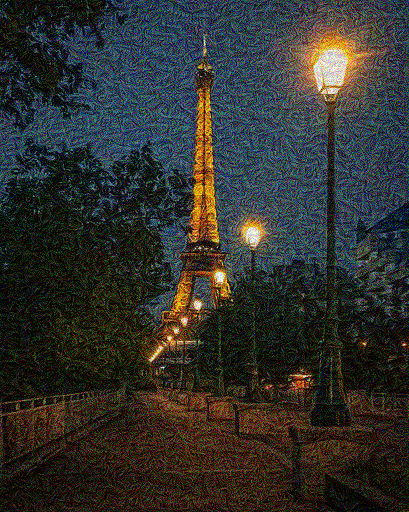

In [80]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

# 4) Run GD to optimize the generated image

In [99]:
def train_model(epochs, steps_per_epoch):
    # Start timing
    start = time.time()


    # Plotting the original content and style images
    plt.figure(figsize=(25,5))
    plt.subplot(1, 5, 1)
    imshow(content_image, 'Content Image')
    plt.subplot(1, 5, 2)
    imshow(style_image, 'Style Image')

    # Training loop
    losses = []
    for n in range(epochs):
        epoch_loss = 0
        for m in range(steps_per_epoch):
            step_loss = train_step(image)
            epoch_loss += step_loss
        losses.append(epoch_loss / steps_per_epoch)

        print(f"Epoch {n+1}/{epochs}, Loss = {losses[-1]}")

        # Plot generated image every 5 epochs
        every_epoch = epochs // 3
        if (n+1) % every_epoch == 0:
            plt.subplot(1, 5, (n+1) // every_epoch + 2)
            imshow(image, f'Generated image/ epoch={n+1}')

    # Save the plot to file
    filename = f'/content/report'
    plt.savefig(filename)  # Save plot to file
    plt.close()

    # End timing
    end = time.time()
    print("Total time: {:.1f}".format(end-start)) # Print total time taken

    return losses

# 5) Result analysis and iterate until get the desired image

In [100]:
content_layers = ['block4_conv1']

style_layers = ['block1_conv1',
                'block1_conv2',
                'block2_conv1',
                'block2_conv2',
                'block3_conv1',
                'block3_conv4',
                'block4_conv1',
                'block4_conv4',
                'block5_conv1',
                'block5_conv4']

style_weights = [0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.2, 0.05, 0.2, 0.10]

extractor = StyleContentModel(content_layers, style_layers, style_weights)

epochs = 30
steps_per_epoch = 10

loss = train_model(epochs, steps_per_epoch)

Epoch 1/30, Loss = 6541995.0
Epoch 2/30, Loss = 6255333.0
Epoch 3/30, Loss = 5975367.0
Epoch 4/30, Loss = 5714380.0
Epoch 5/30, Loss = 5483893.5
Epoch 6/30, Loss = 5289189.0
Epoch 7/30, Loss = 5119986.5
Epoch 8/30, Loss = 4968190.5
Epoch 9/30, Loss = 4823416.0
Epoch 10/30, Loss = 4679567.0
Epoch 11/30, Loss = 4532328.0
Epoch 12/30, Loss = 4386254.5
Epoch 13/30, Loss = 4246637.5
Epoch 14/30, Loss = 4117578.75
Epoch 15/30, Loss = 3999771.25
Epoch 16/30, Loss = 3891445.5
Epoch 17/30, Loss = 3789552.75
Epoch 18/30, Loss = 3690128.5
Epoch 19/30, Loss = 3591569.25
Epoch 20/30, Loss = 3493955.5
Epoch 21/30, Loss = 3398436.0
Epoch 22/30, Loss = 3307562.0
Epoch 23/30, Loss = 3222505.5
Epoch 24/30, Loss = 3142614.75
Epoch 25/30, Loss = 3067367.0
Epoch 26/30, Loss = 2995009.5
Epoch 27/30, Loss = 2924451.5
Epoch 28/30, Loss = 2855172.25
Epoch 29/30, Loss = 2787660.0
Epoch 30/30, Loss = 2722288.5
Total time: 26.8


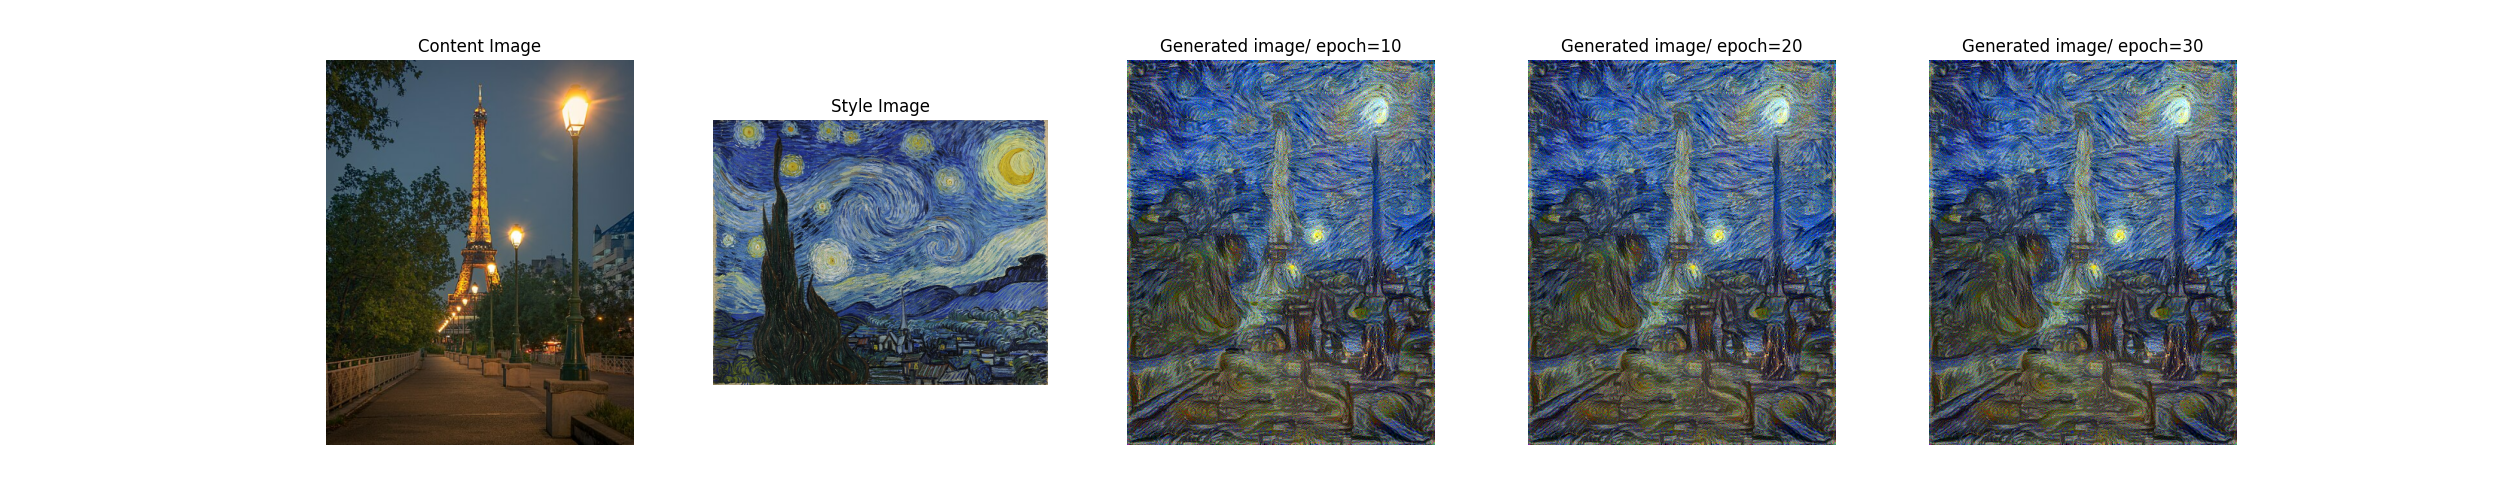

In [101]:
from IPython.display import Image

# Display the image
Image(filename='/content/report.png')


Text(0.5, 0, 'epoch(s)')

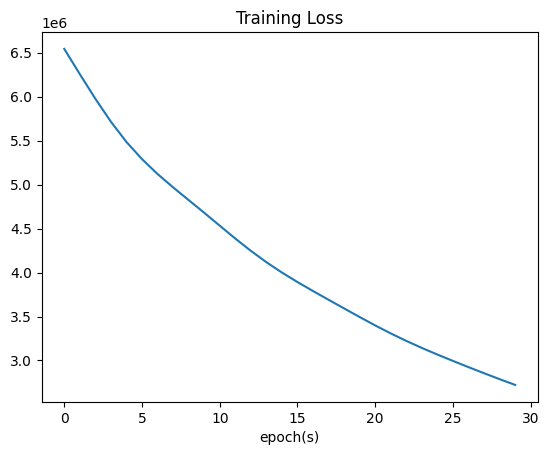

In [103]:
plt.plot(loss)
plt.title("Training Loss")
plt.xlabel("epoch(s)")